# New Section
**Amazon Fine Food Reviews Analysis¶**
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

**Attribute Information:**

Id
ProductId - unique identifier for the product
UserId - unqiue identifier for the user
ProfileName
HelpfulnessNumerator - number of users who found the review helpful
HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
Score - rating between 1 and 5
Time - timestamp for the review
Summary - brief summary of the review
Text - text of the review
Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).


**[Q] How to determine if a review is positive or negative?**

[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

## **Reading Data**

# **Loading the data¶**

The dataset is available in two forms

1 .csv file
2 SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score

In [2]:
# we will read data
con=sqlite3.connect('/content/drive/MyDrive/amazon data/database.sqlite')

In [3]:

# we neglect the review having Score = 3
filtered_data=pd.read_sql_query('''SELECT * FROM Reviews WHERE Score!=3''',con)

In [4]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
def partition(x):
  if x<3:
    return 0
  return 1

In [6]:
actualscore=filtered_data['Score']
positivenegetive=actualscore.map(partition)
filtered_data['Score']=positivenegetive

In [7]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
filtered_data['Score'].value_counts()

1    443777
0     82037
Name: Score, dtype: int64

## **EDA**

In [9]:
display=pd.read_sql_query('''SELECT * FROM Reviews WHERE Score!=3 
                            AND UserId="AR5J8UI46CURR"
                            ORDER BY ProductID''',con)

In [10]:
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...



**Observations: *

1) As in above table, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator.Score,Time, Summary and Text shows same content 

2) Also for all 5 product, shows same time.

3) Here we observed that, product is same, only the flavour is different

4) so we will remove this duplication and keep any one product which all these features so we removing duplicates.

In [11]:
#sort data according to ProductID  in ascending ordre#
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')

In [12]:
final=sorted_data.drop_duplicates(subset={'UserId', 'ProfileName','Time','Text'},keep='first',inplace=False)

In [13]:
final.shape

(364173, 10)

In [14]:
#After removing duplicates we'll see how much % data still remains

((final['Id'].count())/(filtered_data['Id'].count()))*100

69.25890143662969

In [15]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)
final.head()

(364171, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


Now , we do processing like removal of stopwords ,html tags, and make all letters in lowercase

In [16]:
import re
i=0
for sent in final['Text'].values:
  if (re.findall('<.*?>',sent)):
    print(i)
    print(sent)
    break
  i+=1

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [17]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
stop=set(stopwords.words('english'))   #set of stopwordds
sno=nltk.stem.SnowballStemmer('english')  #intialising snowball stemmer

In [20]:
def cleanhtml(sentence):
  cleanr=re.compile('<.*?>')
  cleantext=re.sub(cleanr,' ',sentence)
  return cleantext

def cleanpunc(sentence):
  cleaned=re.sub(r'[?|!|\'|"|#]', r'',sentence)
  cleaned=re.sub(r'[.|,|(|)||\|/]',r'',cleaned)
  return cleaned

In [21]:
print(stop)
print(sno.stem('tasty'))

{'shan', 'doesn', "shouldn't", 'i', 'didn', "doesn't", 'my', 'once', "don't", 'her', 'off', 'again', 'out', 'm', 'on', 'during', "you've", 'o', 'most', 'been', 'if', 'itself', "hasn't", 'is', 'from', 'ma', 'other', 'having', "it's", 'after', 'couldn', 'myself', 'some', 'doing', 'haven', 'ourselves', 'has', 're', 'don', 'needn', 'mustn', "mightn't", 'and', 'him', 'into', 'against', "you'll", 'your', 'yourselves', "shan't", 'does', 'but', 'up', 'below', 'to', 'how', 'such', 'd', 'y', 'there', 'wasn', 't', "that'll", 'his', 'have', 'being', 'only', 'just', 'as', 'all', 'it', 'through', "you're", 'of', 'will', 'this', 'won', 'them', 'our', 'hasn', 'in', "you'd", 'when', 've', 'that', 'or', 'with', 'now', "should've", 'be', 'so', 'they', 'hers', "weren't", 'weren', "didn't", "wouldn't", 'yourself', 'are', 'more', 'isn', 'were', "needn't", "wasn't", 'few', 'whom', 'can', 'where', 'down', 'me', 'both', "mustn't", 'above', 'am', 'aren', 'himself', 'very', 'what', 'at', 'until', 'its', 'then', 

In [22]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.

i=0
final_string=[]
all_positive_words=[]
all_negetive_words=[]
s=''
str1=''
for sent in final['Text'].values:
  filtered_sentence=[]
  sent=cleanhtml(sent)
  for w in sent.split():
    for cleanword in cleanpunc(w).split():
      if ((cleanword.isalpha()) & (len(cleanword)>2)):
        if (cleanword.lower() not in stop):
          s=(sno.stem(cleanword.lower()))
          filtered_sentence.append(s)
          if (final['Score'].values)[i]=='positive':
            all_positive_words.append(s)
          if(final['Score'].values)[i]=='negetive':
            all_negetive_words.append(s)
        else:
          continue
      else:
        continue
  str1= ' '.join(filtered_sentence)
  final_string.append(str1)
  i+=1


In [23]:
final['CleanText']=final_string

In [24]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [25]:
#Store table into sqlite table for future
con1=sqlite3.connect('final.sqlite')
c=con1.cursor()
final.to_sql('Reviews',con1,schema=None,index=True,chunksize=None,dtype=None)

In [26]:
import sqlite3
conn=sqlite3.connect('/content/final.sqlite')

In [27]:
final=pd.read_sql_query('''SELECT * FROM Reviews''',conn)
final.shape

(364171, 12)

In [28]:
#data_p=cleaned[cleaned['Score']==1].sample(n=5000)
#data_n=cleaned[cleaned['Score']==0].sample(n=5000)
#data=pd.concat([data_p,data_n])

In [29]:
final.head(10)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...
5,138693,150511,0006641040,A1C9K534BCI9GO,Laura Purdie Salas,0,0,1,1344211200,Charming and childlike,"A charming, rhyming book that describes the ci...",charm rhyme book describ circumst eat dont chi...
6,138694,150512,0006641040,A1DJXZA5V5FFVA,A. Conway,0,0,1,1338249600,Must have.,I set aside at least an hour each day to read ...,set asid least hour day read son point consid ...
7,138695,150513,0006641040,ASH0DZQQF6AIZ,tessarat,0,0,1,1325721600,A classic,I remembered this book from my childhood and g...,rememb book childhood got kid good rememb kid ...
8,138696,150514,0006641040,A2ONB6ZA292PA,Rosalind Matzner,0,0,1,1313884800,Chicken soup with Rice,It's a great book with adorable illustrations....,great book ador illustr true classic kid love ...
9,138697,150515,0006641040,A2RTT81R6Y3R7X,Lindylu,0,0,1,1303171200,One of our family's favorite books,This book is a family favorite and was read to...,book famili favorit read children small order ...


In [30]:
final['Time']=pd.to_datetime(final['Time'],unit='s')
final=final.sort_values(by='Time')

# **Applying Multinomial Naive Bayes**


# Applying Naive Bayes on BOW 

In [31]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import math

In [32]:
X=final['CleanText']
y=np.array(final['Score'])

In [33]:
X_1,X_test,y_1,y_test=train_test_split(X,y,test_size=0.3,random_state=42)
X_train,X_cv,y_train,y_cv=train_test_split(X_1,y_1,test_size=0.3)


In [34]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect=CountVectorizer()
final_Xtrain=count_vect.fit_transform(X_train)
final_Xcv=count_vect.transform(X_cv)
final_Xtest=count_vect.transform(X_test)



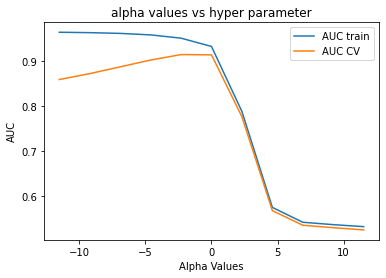

Optimal alpha for which auc is maximum 0.1


In [35]:
auc_train=[]
auc_cv=[]

alpha_values=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]#alpha from 10^-5 to 10^5
for i in alpha_values:
  mnb=MultinomialNB(alpha=i)
  mnb.fit(final_Xtrain,y_train)
  pred=mnb.predict_proba(final_Xcv)[:,1]
  pred1=mnb.predict_proba(final_Xtrain)[:,1]
  auc_train.append(roc_auc_score(y_train,pred1))
  auc_cv.append(roc_auc_score(y_cv,pred))


optimal_alpha=alpha_values[auc_cv.index(max(auc_cv))]
alpha_values=[math.log(x) for x in alpha_values]

fig=plt.figure()
ax=plt.subplot(111)

ax.plot(alpha_values,auc_train,label='AUC train')
ax.plot(alpha_values,auc_cv,label='AUC CV')
plt.title('alpha values vs hyper parameter')
plt.xlabel('Alpha Values')
plt.ylabel('AUC')
plt.legend()
plt.show()
print('Optimal alpha for which auc is maximum',optimal_alpha)


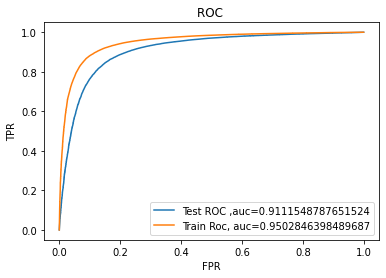

In [39]:
#ROC for alpha =0.1

mnb=MultinomialNB(alpha=0.1)
mnb.fit(final_Xtrain,y_train)

predi=mnb.predict_proba(final_Xtest)[:,1]
fpr1,tpr1,thresholds1=metrics.roc_curve(y_test,predi)

pred=mnb.predict_proba(final_Xtrain)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred)

fig=plt.figure()
ax=plt.subplot(111)
ax.plot(fpr1,tpr1,label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2,tpr2,label='Train Roc, auc='+str(roc_auc_score(y_train,pred)))
plt.title('ROC ')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()


In [38]:
import sklearn.metrics as metrics

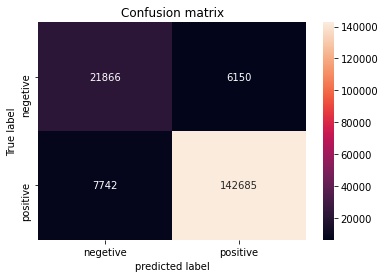

In [40]:
#confusion matrix using heatmap for train data
from sklearn.metrics import confusion_matrix
mnb=MultinomialNB(alpha=0.1)
mnb.fit(final_Xtrain,y_train)
predic=mnb.predict(final_Xtrain)
import seaborn as sns
conf_mat=confusion_matrix(y_train,predic)
class_label=['negetive','positive']
df=pd.DataFrame(conf_mat,index=class_label,columns=class_label)
sns.heatmap(df,annot=True,fmt='d')
plt.title('Confusion matrix')
plt.xlabel('predicted label')
plt.ylabel('True label')
plt.show()

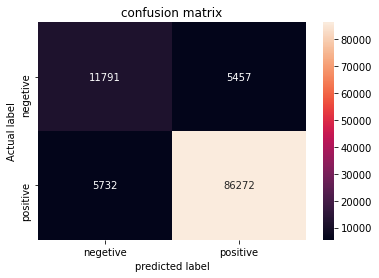

In [41]:
#confusion matrix using heatmap for test data
mnb=MultinomialNB(alpha=0.1)
mnb.fit(final_Xtrain,y_train)
predic=mnb.predict(final_Xtest)
import seaborn as sns
conf_mat=confusion_matrix(y_test,predic)
class_label=['negetive','positive']
df=pd.DataFrame(conf_mat,index=class_label,columns=class_label)
sns.heatmap(df,annot=True,fmt='d')
plt.title('confusion matrix')
plt.xlabel('predicted label')
plt.ylabel('Actual label')
plt.show()

### Top 10 important features of positive class

In [42]:
model=MultinomialNB(alpha=0.1)
model.fit(final_Xtrain,y_train)
features=model.feature_log_prob_ #log probability of features for given class
feature_names=count_vect.get_feature_names()
negetive_features=np.argsort(features[0])[::-1]
positive_features=np.argsort(features[1])[::-1]
print('Top 10 important features of positive class for BOW')
for i in list(positive_features[1:10]):
  print(feature_names[i])

Top 10 important features of positive class for BOW
tast
good
flavor
love
use
great
one
product
tri


In [43]:
print('Top 10 import features of negetive class')
for i in list(negetive_features[0:10]):
  print(feature_names[i])

Top 10 import features of negetive class
tast
like
product
one
flavor
tri
would
use
good
coffe


# Applying Naive Bayes on TFIDF

In [44]:
X=final['CleanText']
y=np.array(final['Score'])
X_1,X_test,y_1,y_test=train_test_split(X,y,test_size=0.3,random_state=42)
X_train,X_cv,y_train,y_cv=train_test_split(X_1,y_1,test_size=0.3, random_state=40)

In [45]:
X_train

142729    tea tast bag torn place creas side one side ba...
254616    product excel qualiti great tast import india ...
295941    great older dog either lost chew teeth rather ...
37676     tea crisp clean fresh tast lemon ginger get en...
254100    honest dont understand murmur product sweet fa...
                                ...                        
163774    dont trust ate hand feel like might give migra...
42255     ive vegan six year know thing two rice bean de...
6558      deal rip tea tast noth like suppos item add sh...
78761     skeptic first heard product decid give tri ama...
60164     love pineappl wont disappoint item half sweet ...
Name: CleanText, Length: 178443, dtype: object

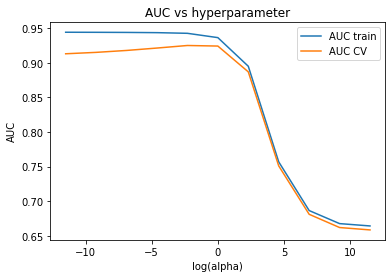

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect=TfidfVectorizer(min_df=10)
X_train=tf_idf_vect.fit_transform(X_train)
X_cv=tf_idf_vect.transform(X_cv)
X_test=tf_idf_vect.transform(X_test)

auc_cv=[]
auc_train=[]
alpha_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
    
for i in alpha_values:
    mnb = MultinomialNB(alpha = i)
    mnb.fit(X_train,y_train)
    pred=mnb.predict_proba(X_cv)[:,1]
    pred1=mnb.predict_proba(X_train)[:,1]
    auc_train.append(roc_auc_score(y_train,pred1))
    auc_cv.append(roc_auc_score(y_cv,pred))
    
optimal_alpha= alpha_values[auc_cv.index(max(auc_cv))]
alpha_values=[math.log(x) for x in alpha_values]
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(alpha_values, auc_train, label='AUC train')
ax.plot(alpha_values, auc_cv, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('log(alpha)')
plt.ylabel('AUC')
ax.legend()
plt.show()

In [47]:
print('optimal alpha which auc is maximum',optimal_alpha)

optimal alpha which auc is maximum 0.1


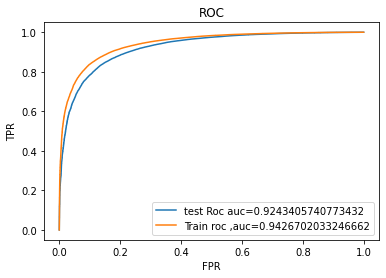

In [48]:
mnb=MultinomialNB(alpha=0.1)
mnb.fit(X_train,y_train)
predi=mnb.predict_proba(X_test)[:,1]
fpr1,tpr1,thresholds1=metrics.roc_curve(y_test,predi)

pred=mnb.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred)

fig=plt.figure()
ax=plt.subplot(111)
ax.plot(fpr1,tpr1,label='test Roc auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2,tpr2,label='Train roc ,auc='+str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

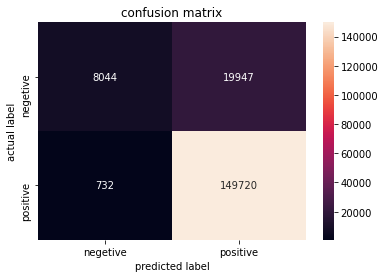

In [49]:
#confusion matrix using heatmap for train data

from sklearn.metrics import confusion_matrix
mnb=MultinomialNB(alpha=0.1)
mnb.fit(X_train,y_train)
predic=mnb.predict(X_train)
import seaborn as sns
class_label=['negetive','positive']
confu=confusion_matrix(y_train,predic)
df=pd.DataFrame(confu,index=class_label,columns=class_label)
sns.heatmap(df, annot=True,fmt='d')
plt.title('confusion matrix')
plt.xlabel('predicted label')
plt.ylabel('actual label')
plt.show()

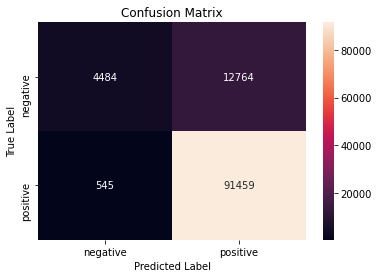

In [50]:
#Confusion matrix using heatmap for test data
from sklearn.metrics import confusion_matrix
mnb=MultinomialNB(alpha=0.1)
mnb.fit(X_train,y_train)
predic=mnb.predict(X_test)
import seaborn as sns
conf_mat = confusion_matrix(y_test, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Top 10 important features of positive class

In [51]:
model=MultinomialNB(alpha=0.1)
model.fit(X_train,y_train)
features=model.feature_log_prob_
feature_names=tf_idf_vect.get_feature_names()
negetive_features=np.argsort(features[0])[::-1]
positive_features=np.argsort(features[1])[::-1]
print('Top 10 features of positive class from TFIDF')

for i in list(positive_features[0:10]):
  print(feature_names[i])

Top 10 features of positive class from TFIDF
great
love
tast
good
like
flavor
tea
coffe
product
use


In [52]:
# Please write all the code with proper documentation
print("Top 10 important features of negative class from TFIDF")
for i in list(negetive_features[0:10]):
    print(feature_names[i])

Top 10 important features of negative class from TFIDF
tast
like
product
would
flavor
one
coffe
buy
tri
order


In [55]:
from prettytable import PrettyTable
x= PrettyTable()
x.field_names=['vectorizer','Hyperparameter(alpha)','AUC']
x.add_row(['BOW',0.1,0.91])
x.add_row(['TFIDF',0.1,0.92])
print(x)

+------------+-----------------------+------+
| vectorizer | Hyperparameter(alpha) | AUC  |
+------------+-----------------------+------+
|    BOW     |          0.1          | 0.91 |
|   TFIDF    |          0.1          | 0.92 |
+------------+-----------------------+------+
